# PCA task

## Run this to install the required packages

In [8]:
import sys
!{sys.executable} -m pip install --user -r requirements.txt

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import warnings
from sklearn.decomposition import PCA
from utils import read_datasets, get_score, plot_anomalies
import matplotlib.dates as mdates

warnings.filterwarnings("ignore")

## Functions used for PCA task

In [24]:
def plot_cumulative_explained_var(dataset):
    """
    Plots the cumulative explained variance over the number of principal components
    :param dataset: Dataset to apply PCA
    """
    # apply pca for the maximum number of features
    pca = PCA(n_components=dataset.shape[1])
    pca.fit(dataset)

    # compute cumulative explained variance as the components are increasing
    total_var = pca.explained_variance_ratio_.cumsum()

    # plot cumulative variance
    x_axis = np.arange(1, (len(pca.explained_variance_ratio_) + 1), 1)
    plt.title('Cumulative Variance of Principal Components')
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Explained Variance')
    plt.plot(x_axis, total_var)
    plt.tight_layout()
    plt.grid()
    plt.savefig('plots/pca/pca_var.png', bbox_inches='tight')
    # plt.show()

In [25]:
def get_num_of_components(dataset, conf):
    """
    Finds the minimum number of principal components that provide the given explained variance
    :param dataset: Dataset to apply PCA
    :param explained_var: Lower bound of explained variance we want
    :return: minimum number of principal components
    """
    # apply pca for the maximum number of features

    pca = PCA(n_components=dataset.shape[1])
    pca.fit(dataset)

    # compute cumulative explained variance as the components are increasing
    total_var = pca.explained_variance_ratio_.cumsum()
    # find minimum number of principal components that provide the given explained variance
    n_components = [i + 1 for i, var in enumerate(total_var) if var > conf][0]
    return n_components


In [26]:
def get_threshold(pca, components, conf):
    """
    Calculate the threshold, according to the paper "Diagnosing Network-Wide Traffic Anomalies"
    :param pca: PCA fitted to the tuning dataset
    :param components: number of components found by the cumulative variance
    :return: Classification threshold
    """
    sorted_eigen = np.sort(pca.explained_variance_)
    sorted_eigen = sorted_eigen[-1::-1]

    lambda1 = sorted_eigen
    lambda2 = np.power(sorted_eigen, 2)
    lambda3 = np.power(sorted_eigen, 3)

    fi1 = sum(lambda1[components:])
    fi2 = sum(lambda2[components:])
    fi3 = sum(lambda3[components:])
    h0 = 1 - 2.0 * fi1 * fi3 / (3 * (fi2 ** 2))
    Ca = 1 - conf
    threshold = fi1 * np.power((1.0 * Ca * np.sqrt(2 * fi2 * (h0 ** 2)) / fi1)
                               + 1 + (1.0 * fi2 * h0 * (h0 - 1) / (fi1 ** 2)), 1.0 / h0)
    # print
    # fi1, fi2, fi3, h0, threshold
    return threshold

## Plot cumulative variance of principal components

anomaly_detection
Number of components for explained variance 0.99 is 15


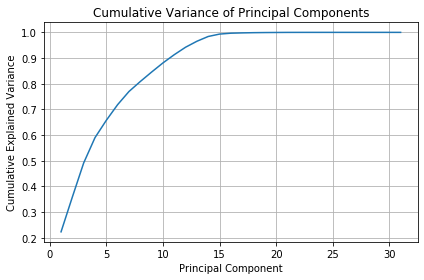

In [27]:

# read all datasets
scaled_df1, train_y1, scaled_df2, train_y2, scaled_test_df, y = read_datasets()

# coluns to drop, status signals
drop_columns = ['S_PU1', 'S_PU2', 'S_PU3', 'S_PU4', 'S_PU5', 'S_PU6', 'S_PU7', 'S_PU8', 'S_PU9', 'S_PU10', 'S_PU11',
                'S_V2']

# drop columns on all the 3 datasets
pca_train_data1 = scaled_df1.select_dtypes(include=['float64']).drop(drop_columns, axis=1)

plot_cumulative_explained_var(pca_train_data1)
print('Number of components for explained variance {0} is {1}'.format(0.99, get_num_of_components(pca_train_data1,
                                                                                                  conf=0.99)))

#  PCA task implementation

## Rea datasets and drop unused columns

In [28]:
# read training 1 dataset
scaled_df1, train_y1, scaled_df2, train_y2, scaled_test_df, y = read_datasets()

# coluns to drop, status signals
drop_columns = ['S_PU1', 'S_PU2', 'S_PU3', 'S_PU4', 'S_PU5', 'S_PU6', 'S_PU7', 'S_PU8', 'S_PU9', 'S_PU10', 'S_PU11',
                'S_V2']

# drop columns on all the 3 datasets
pca_train_data1 = scaled_df1.drop(drop_columns, axis=1)
pca_train_data2 = scaled_df2.drop(drop_columns, axis=1)
pca_test_data = scaled_test_df.drop(drop_columns, axis=1)

anomaly_detection


## Remove abnormalities from training dataset 1

Threshold is 1.1128169485837445e-14


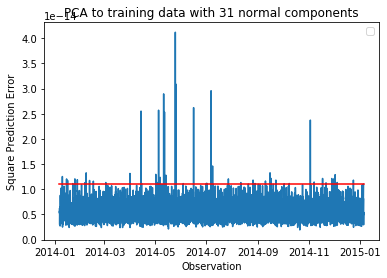

Shape before is (8761, 31)
Shape after is (8697, 31)


In [29]:
# apply PCA on training dataset 1
pca = PCA(n_components=pca_train_data1.shape[1])
pca.fit(pca_train_data1)
# compute residuals
residuals = pca_train_data1 - pca.inverse_transform(pca.transform(pca_train_data1))
res_norm = np.sqrt(np.square(residuals).sum(axis=1))
# find threshold for outlier detection => mean + std
threshold = np.mean(res_norm) + 3* np.std(res_norm)  # increase std*(2 or 3), increases TP by 30 and FP by 50

print('Threshold is {}'.format(threshold))
# find outliers
predicted_positives = np.where(res_norm > threshold)[0]
# plot residuals and point outliers
plt.plot(res_norm)
thresh_handle = plt.plot_date([res_norm.index[0], res_norm.index[-1]], [threshold, threshold], fmt='-', color='r')
plt.ylabel("Square Prediction Error")
plt.xlabel("Observation")
plt.title("PCA to training data with " + str(pca_train_data1.shape[1]) + " normal components")
plt.legend([thresh_handle], ["Sample threshold"])
plt.show()
print("Shape before is {}".format(str(pca_train_data1.shape)))
pca_train_data1_without_outliers = pca_train_data1.drop(pca_train_data1.index[predicted_positives])
print("Shape after is {}".format(str(pca_train_data1_without_outliers.shape)))

## Use training dataset 2 to determine threshold

In [30]:
# we use training dataset 2 to find the optimal classification threshold
pca = PCA(n_components=pca_train_data2.shape[1])
pca.fit(pca_train_data2)
components_dataset2 = get_num_of_components(pca_train_data2, 0.95)
threshold = get_threshold(pca, components_dataset2, conf=0.95)

# another way to get a threshold
# residuals = pca_train_data2 - pca.inverse_transform(pca.transform(pca_train_data2))
# res_norm = np.sqrt(np.square(residuals).sum(axis=1))
# total_errors = [err for i, err in enumerate(res_norm) if train_y2[i] == 1]
# threshold = np.max(total_errors) # computed classification threshold

## Apply PCA to test dataset

TP: 224, FP: 9, TPR: 0.5503685503685504, TNR: 0.9946492271105827
Sttd: 0.9556253270538985, Scm: 0.7725088887395666, S: 0.8640671078967326


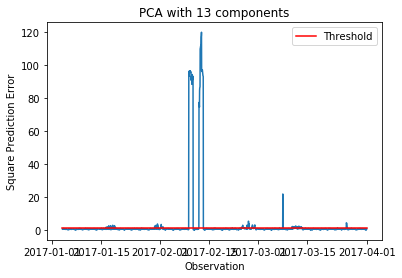

In [31]:
# apply PCA for test dataset
components = get_num_of_components(pca_train_data1_without_outliers, 0.99)  # determine the number of PCA components
pca = PCA(n_components=components)
pca.fit(pca_train_data1_without_outliers)
residuals = pca_test_data - pca.inverse_transform(pca.transform(pca_test_data))
res_norm = np.sqrt(np.square(residuals).sum(axis=1))
# find indices of predicted and true positives
predicted_anomalies = np.where(res_norm > threshold)[0]
true_anomalies = np.where(y == 1)[0]

# compute scores
[tp, fp, fn, tn, tpr, tnr, Sttd, Scm, S] = get_score(predicted_anomalies, true_anomalies, y=y)

print("TP: {0}, FP: {1}, TPR: {2}, TNR: {3}".format(tp, fp, tpr, tnr))
print("Sttd: {0}, Scm: {1}, S: {2}".format(Sttd, Scm, S))

# plot residuals and threshold line
plt.figure()
plt.plot(res_norm)
thresh_handle, = plt.plot_date([res_norm.index[0], res_norm.index[-1]], [threshold, threshold], fmt='-', color='r')
plt.ylabel("Square Prediction Error")
plt.xlabel("Observation")
plt.title("PCA with " + str(components) + " components")
plt.legend([thresh_handle], ["Threshold"])
plt.show()

## Combine all predictions

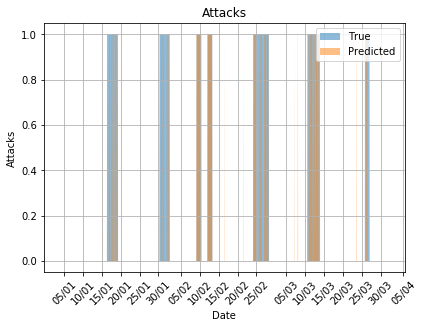

In [32]:
# plot attacks detected
all_predictions = [1 if res > threshold else 0 for res in res_norm]
plot_anomalies(y, all_predictions)